In [1]:
import string, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import jieba
import operator
import zhconv

import warnings
warnings.filterwarnings(action='ignore',category=UserWarning,module='gensim')
from gensim.models import Word2Vec

from keras.preprocessing import sequence
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model

Using TensorFlow backend.


In [2]:
from collections import Counter

In [3]:
comments_path = r'../dataset/movie_comments.csv'
model_path = r'../models/zhwiki.50d.word2vec'

# 影评数据

In [4]:
comments = pd.read_csv(comments_path, low_memory=False)
comments.head(10)

,id,link,name,comment,star
0,1,https://movie.douban.com/subject/26363254/,战狼2,吴京意淫到了脑残的地步，看了恶心想吐,1
1,2,https://movie.douban.com/subject/26363254/,战狼2,首映礼看的。太恐怖了这个电影，不讲道理的，完全就是吴京在实现他这个小粉红的英雄梦。各种装备轮...,2
2,3,https://movie.douban.com/subject/26363254/,战狼2,吴京的炒作水平不输冯小刚，但小刚至少不会用主旋律来炒作…吴京让人看了不舒服，为了主旋律而主旋...,2
3,4,https://movie.douban.com/subject/26363254/,战狼2,凭良心说，好看到不像《战狼1》的续集，完虐《湄公河行动》。,4
4,5,https://movie.douban.com/subject/26363254/,战狼2,中二得很,1
5,6,https://movie.douban.com/subject/26363254/,战狼2,“犯我中华者，虽远必诛”，吴京比这句话还要意淫一百倍。,1
6,7,https://movie.douban.com/subject/26363254/,战狼2,脑子是个好东西，希望编剧们都能有。,2
7,8,https://movie.douban.com/subject/26363254/,战狼2,三星半，实打实的7分。第一集在爱国主旋律内部做着各种置换与较劲，但第二集才真正显露吴京的野心...,4
8,9,https://movie.douban.com/subject/26363254/,战狼2,开篇长镜头惊险大气引人入胜 结合了水平不俗的快剪下实打实的真刀真枪 让人不禁热血沸腾 特别弹...,4
9,10,https://movie.douban.com/subject/26363254/,战狼2,15/100吴京的冷峰在这部里即像成龙，又像杰森斯坦森，但体制外的同类型电影，主角总是代表个...,1


In [5]:
comments.drop(['id','link','name'], axis=1, inplace=True)
print(comments.info())
comments.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261497 entries, 0 to 261496
Data columns (total 2 columns):
comment    261495 non-null object
star       261497 non-null object
dtypes: object(2)
memory usage: 4.0+ MB
None


,comment,star
0,吴京意淫到了脑残的地步，看了恶心想吐,1
1,首映礼看的。太恐怖了这个电影，不讲道理的，完全就是吴京在实现他这个小粉红的英雄梦。各种装备轮...,2
2,吴京的炒作水平不输冯小刚，但小刚至少不会用主旋律来炒作…吴京让人看了不舒服，为了主旋律而主旋...,2
3,凭良心说，好看到不像《战狼1》的续集，完虐《湄公河行动》。,4
4,中二得很,1
5,“犯我中华者，虽远必诛”，吴京比这句话还要意淫一百倍。,1
6,脑子是个好东西，希望编剧们都能有。,2
7,三星半，实打实的7分。第一集在爱国主旋律内部做着各种置换与较劲，但第二集才真正显露吴京的野心...,4
8,开篇长镜头惊险大气引人入胜 结合了水平不俗的快剪下实打实的真刀真枪 让人不禁热血沸腾 特别弹...,4
9,15/100吴京的冷峰在这部里即像成龙，又像杰森斯坦森，但体制外的同类型电影，主角总是代表个...,1


#### 删除评论为空的行

In [6]:
comments = comments.dropna()
print(comments.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261495 entries, 0 to 261496
Data columns (total 2 columns):
comment    261495 non-null object
star       261495 non-null object
dtypes: object(2)
memory usage: 6.0+ MB
None


#### 删除评分不为数值的行

In [7]:
comments = comments[comments['star'].isin(['1', '2', '3', '4', '5'])]
print(comments.info())
comments['star'] = comments['star'].astype('int')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261494 entries, 0 to 261496
Data columns (total 2 columns):
comment    261494 non-null object
star       261494 non-null object
dtypes: object(2)
memory usage: 6.0+ MB
None


#### 查看评分分数分布:
- 不同类评分的分布比较不均匀，特别是 1、2 分
- **todo：处理这种不平衡**

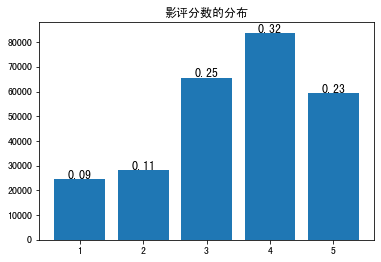

In [8]:
x = np.arange(1,6)
nums = [len(comments[comments['star']==i]) for i in x]

def plot_score_distribution(x, nums):
    plt.bar(x, nums)
   
    plt.title('影评分数的分布')
    for x,y in zip(x,nums):
        plt.text(x,y+100,round(y/sum(nums),2),ha='center',fontsize=12)
    plt.show()
    
plot_score_distribution(x, nums) 

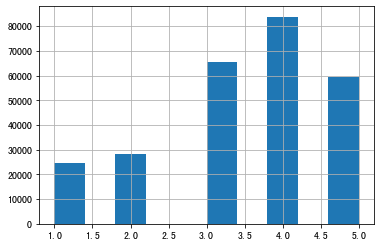

In [9]:
comments['star'].hist()

#### 文本预处理
- 删除符号
- 繁体转简体
- 分词后以空格连接
- 英文大写转小写

In [10]:
punct = r"，。！？、；：“”\n＂＃＄％＆＇（）＊＋－／＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､〃《》「」『』【】〔〕〖〗〘〙〚〛〜〝〟〰〾〿–—‛„‟…‧﹏★☆•→▽"

In [11]:
def clean_special_chars(text):
    re_tok = re.compile(f'([{string.punctuation}{punct}])')
    return re_tok.sub(r' ', text)

In [12]:
def simplify(text):
    return zhconv.convert(text, 'zh-cn')

In [13]:
def cut_join(text):
    space = ' '
    words = jieba.cut(text)
    return space.join([w.lower() for w in words if not w.isspace()])

In [14]:
def preprocess(text):
    text = clean_special_chars(text)
    text = simplify(text)
    text = cut_join(text)
    return text

In [15]:
comments['cleaned_comment'] = comments['comment'].apply(preprocess)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\yangbin\AppData\Local\Temp\jieba.cache
Loading model cost 1.140 seconds.
Prefix dict has been built succesfully.


In [18]:
comments['cleaned_comment'].head(10)

0                         吴京 意淫 到 了 脑残 的 地步 看 了 恶心 想 吐
1    首映礼 看 的 太 恐怖 了 这个 电影 不讲道理 的 完全 就是 吴京 在 实现 他 这个...
2    吴京 的 炒作 水平 不输 冯小刚 但小刚 至少 不会 用 主旋律 来 炒作 吴京 让 人 ...
3                     凭良心说 好 看到 不像 战狼 1 的 续集 完虐 湄公河 行动
4                                                中二得 很
5                   犯 我 中华 者 虽远必 诛 吴京 比 这句 话 还要 意淫 一百倍
6                            脑子 是 个 好 东西 希望 编剧 们 都 能 有
7    三星 半 实打实 的 7 分 第一集 在 爱国 主旋律 内部 做 着 各种 置换 与 较劲 ...
8    开篇 长镜头 惊险 大气 引人入胜 结合 了 水平 不俗 的 快 剪下 实打实 的 真刀真枪...
9    15 100 吴京 的 冷峰 在 这部 里 即 像 成龙 又 像杰 森斯坦 森 但 体制 外...
Name: cleaned_comment, dtype: object

#### 查看影评的字数分布
- 5% 的影评字数少于 3 个，删除这些数据；删除后对类别分布无影响
- **todo：更好的方法处理不同影评的这种字数差别**

In [19]:
comments['comment_length'] = comments['comment'].apply(len).astype('int')

In [20]:
min_ = comments['comment_length'].min()
max_ = comments['comment_length'].max()
median = comments['comment_length'].median()
mean = comments['comment_length'].mean()
mode = comments['comment_length'].mode()[0]
print(min_, max_, median, mean, mode)

1 4247 19.0 34.62489770319778 7


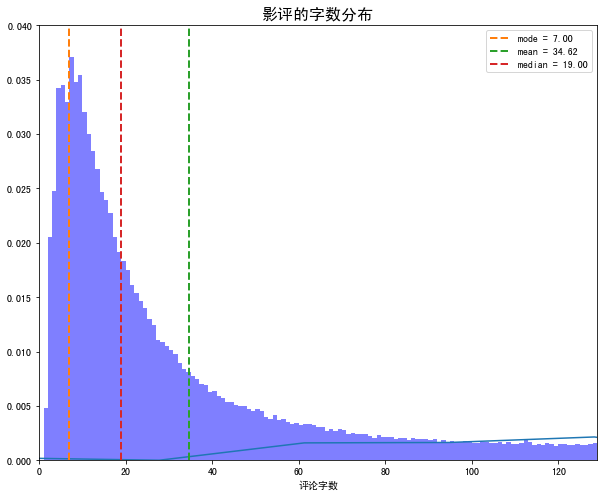

In [21]:
fig, ax = plt.subplots(figsize=(10,8))
sn.distplot(comments['comment_length'], bins=comments['comment_length'].max(),
            hist_kws={"alpha": 0.5, "color": "blue"}, ax=ax)
ax.set_xlim(left=0, right=np.percentile(comments['comment_length'], 95))
ax.set_xlabel('评论字数')
ymax = 0.04
plt.ylim(0, ymax)
ax.plot([mode, mode], [0, ymax], '--', label=f'mode = {mode:.2f}', linewidth=2)
ax.plot([mean, mean], [0, ymax], '--', label=f'mean = {mean:.2f}', linewidth=2)
ax.plot([median, median], [0, ymax], '--',
        label=f'median = {median:.2f}', linewidth=2)
ax.set_title('影评的字数分布', fontsize=16)
plt.legend()
plt.show()

In [22]:
np.percentile(comments['comment_length'], 5)

3.0

In [23]:
comments = comments[comments['comment_length']>3]
print(comments.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248396 entries, 0 to 261496
Data columns (total 4 columns):
comment            248396 non-null object
star               248396 non-null int32
cleaned_comment    248396 non-null object
comment_length     248396 non-null int32
dtypes: int32(2), object(2)
memory usage: 7.6+ MB
None


**字数最少（4个字）的评论的的评分分布**

In [24]:
len(comments[comments['comment_length']==4])

8947

D:\Program\Anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


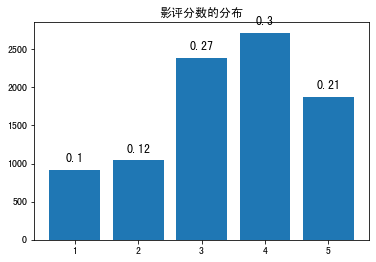

In [25]:
x = np.arange(1,6)
nums = [len(comments[comments['comment_length']==4][comments['star']==i]) for i in x]
plot_score_distribution(x, nums)

In [26]:
comments[comments['comment_length']==4][['comment','star']][:20]

,comment,star
4,中二得很,1
67,3d扣分,2
141,爱与坚持,3
162,勇敢面对,4
180,励志大片,5
208,MIT？,4
220,MIT？,4
251,平民励志,4
258,平民励志,4
265,苦尽甘来,4


# 将文本转换成向量

#### 词向量
- 使用中文维基的预训练词向量

In [27]:
model = Word2Vec.load(model_path)
wv = model.wv
del model

D:\Program\Anaconda3\envs\nlp\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [28]:
len(wv.vocab)

845989

In [29]:
wv.most_similar(['吴京'])

[('张静初', 0.8863259553909302),
 ('刘烨', 0.8568055629730225),
 ('廖凡', 0.8530554175376892),
 ('张震', 0.8500816822052002),
 ('张涵予', 0.8481923341751099),
 ('胡军', 0.8465080857276917),
 ('段奕宏', 0.8462876081466675),
 ('黄轩', 0.844296932220459),
 ('黄渤', 0.8436167240142822),
 ('喻亢', 0.8426705598831177)]

In [30]:
index = wv.index2word.index('吴京')
index

48404

#### 创建词汇表

In [96]:
def build_vocab(texts):
    vocab = {}
    for t in texts:
        words = t.strip().split()
        for word in words:
            if word != 'unkown':
                vocab[word] = vocab.get(word, 0) + 1
    return vocab

In [35]:
vocab = build_vocab(comments['cleaned_comment'])
vocab

{'吴京': 279,
 '意淫': 279,
 '到': 10358,
 '了': 102050,
 '脑残': 316,
 '的': 328370,
 '地步': 197,
 '看': 34252,
 '恶心': 922,
 '想': 7471,
 '吐': 565,
 '首映礼': 42,
 '太': 12975,
 '恐怖': 596,
 '这个': 10269,
 '电影': 34593,
 '不讲道理': 8,
 '完全': 4152,
 '就是': 14014,
 '在': 31161,
 '实现': 270,
 '他': 10655,
 '小': 6647,
 '粉红': 39,
 '英雄': 1705,
 '梦': 871,
 '各种': 3136,
 '装备': 80,
 '轮番': 21,
 '上场': 17,
 '视': 29,
 '物理': 63,
 '逻辑': 1414,
 '于': 1783,
 '不顾': 57,
 '不得不': 670,
 '说': 11123,
 '有钱': 205,
 '真': 5180,
 '好': 22827,
 '随意': 170,
 '胡闹': 45,
 '炒作': 70,
 '水平': 819,
 '不输': 48,
 '冯小刚': 266,
 '但小刚': 1,
 '至少': 912,
 '不会': 2684,
 '用': 3944,
 '主旋律': 923,
 '来': 5251,
 '让': 13704,
 '人': 24157,
 '不': 28318,
 '舒服': 607,
 '为了': 3506,
 '而': 6535,
 '煽情': 1171,
 '觉得': 8878,
 '是': 72707,
 '个': 6664,
 '大': 5911,
 '做作': 822,
 '谎言': 266,
 '家': 564,
 '7': 1719,
 '29': 96,
 '更新': 87,
 '片子': 9578,
 '整体': 1410,
 '不如': 1795,
 '湄公河': 57,
 '行动': 187,
 '1': 3510,
 '不够': 1818,
 '流畅': 699,
 '编剧': 2270,
 '有毒': 38,
 '台词': 2368,
 '尴尬': 1655,
 '2': 3

In [36]:
print("评论总单词数：{}；词汇表单词个数：{}".format(sum(vocab.values()), len(vocab)))

评论总单词数：4558546；词汇表单词个数：139721


In [97]:
word2index = {'unkown':0}
for word,_ in vocab.items():
    word2index[word] = len(word2index)

In [98]:
word2index

{'unkown': 0,
 '吴京': 1,
 '意淫': 2,
 '到': 3,
 '了': 4,
 '脑残': 5,
 '的': 6,
 '地步': 7,
 '看': 8,
 '恶心': 9,
 '想': 10,
 '吐': 11,
 '首映礼': 12,
 '太': 13,
 '恐怖': 14,
 '这个': 15,
 '电影': 16,
 '不讲道理': 17,
 '完全': 18,
 '就是': 19,
 '在': 20,
 '实现': 21,
 '他': 22,
 '小': 23,
 '粉红': 24,
 '英雄': 25,
 '梦': 26,
 '各种': 27,
 '装备': 28,
 '轮番': 29,
 '上场': 30,
 '视': 31,
 '物理': 32,
 '逻辑': 33,
 '于': 34,
 '不顾': 35,
 '不得不': 36,
 '说': 37,
 '有钱': 38,
 '真': 39,
 '好': 40,
 '随意': 41,
 '胡闹': 42,
 '炒作': 43,
 '水平': 44,
 '不输': 45,
 '冯小刚': 46,
 '但': 47,
 '小刚': 48,
 '至少': 49,
 '不会': 50,
 '用': 51,
 '主旋律': 52,
 '来': 53,
 '让': 54,
 '人': 55,
 '不': 56,
 '舒服': 57,
 '为了': 58,
 '而': 59,
 '煽情': 60,
 '觉得': 61,
 '是': 62,
 '个': 63,
 '大': 64,
 '做作': 65,
 '谎言': 66,
 '家': 67,
 '更新': 68,
 '片子': 69,
 '整体': 70,
 '不如': 71,
 '湄公河': 72,
 '行动': 73,
 '不够': 74,
 '流畅': 75,
 '编剧': 76,
 '有毒': 77,
 '台词': 78,
 '尴尬': 79,
 '刻意': 80,
 '显得': 81,
 '如此': 82,
 '不合时宜': 83,
 '又': 84,
 '多余': 85,
 '凭良心说': 86,
 '看到': 87,
 '不像': 88,
 '战狼': 89,
 '续集': 90,
 '完虐': 91,
 '中二': 92,


#### 评论中没有词向量中的词
- 解决措施：继续分词
- 拼写纠错：如“鸡冻”--> “激动”

In [39]:
def check_coverage(vocab, wv):
    known_words = {}
    unknown_words = {}
    no_known_words = 0
    no_unknown_words = 0
    for word in vocab:
        try:
            known_words[word] = wv[word]
            no_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            no_unknown_words += vocab[word]
    print('词汇表中 {:.2%} 的单词有词向量'.format(len(known_words) / len(vocab)))
    print('评论的所有单词中 {:.2%} 的单词有词向量'.format(no_known_words / (no_known_words + no_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]
    return unknown_words

In [40]:
unknown_words = check_coverage(vocab, wv)

词汇表中 69.33% 的单词有词向量
评论的所有单词中 97.05% 的单词有词向量


In [42]:
len(unknown_words)

42851

In [41]:
sorted(unknown_words, key=lambda w:len(w[0]), reverse=True)[:50]

[('ahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhotdwarvesatyourservice',
  1),
 ('blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah',
  1),
 ('hiusjufbjijhjjsfightdjsiosnwnbombsisjwnexplosionwhshbdbwwhatfuckjusthappenddhsjsndhdjfighrekizjekilldbiejsshotdhsjsnthatbitchsjdjjffuckjejsh',
  1),
 ('bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbest',
  2),
 ('bce43fd38b93b6c518d056245a8a4de28880c502e41eebc1978142bcb20fadc9bc54d7cbb6a0',
  1),
 ('prprprprprprprprprprprprprprprprprprprprpr', 2),
 ('97db28f635ac65285bac7790ca7a36ca2234679201', 1),
 ('3a3e3c800a74582d2295df84c6624848bd6ed54a', 2),
 ('4ee833da28c2d1

In [44]:
sorted(unknown_words, key=lambda w:w[1], reverse=True)[:50]

[('2', 3789),
 ('3', 3620),
 ('1', 3510),
 ('5', 3353),
 ('4', 2237),
 ('7', 1719),
 ('8', 1516),
 ('10', 1476),
 ('6', 1216),
 ('3d', 1055),
 ('0', 919),
 ('9', 822),
 ('20', 660),
 ('12', 535),
 ('90', 501),
 ('30', 445),
 ('加一星', 443),
 ('11', 432),
 ('星给', 420),
 ('80', 413),
 ('一般般', 410),
 ('⋯', 386),
 ('15', 341),
 ('100', 340),
 ('007', 322),
 ('13', 315),
 ('50', 272),
 ('2016', 269),
 ('2008', 268),
 ('2012', 260),
 ('2015', 249),
 ('2014', 242),
 ('2013', 239),
 ('14', 236),
 ('’', 233),
 ('18', 228),
 ('17', 226),
 ('60', 223),
 ('cctv6', 216),
 ('21', 213),
 ('2010', 210),
 ('太赞', 209),
 ('╯', 205),
 ('2017', 205),
 ('70', 204),
 ('￣', 203),
 ('‘', 202),
 ('2009', 201),
 ('没劲', 200),
 ('╰', 198)]

In [50]:
'2' in wv

False

##### 没有词向量的汉语短语

In [51]:
def is_chinese(str):
    for s in str:
        if  u'\u4e00' <= s <= u'\u9fff':
            return True
    return False

In [52]:
is_chinese('君子之交淡如水')

True

In [53]:
unknown_chinese=[(w,c) for w, c in unknown_words if is_chinese(w)]
len(unknown_chinese)

37180

In [54]:
sorted(unknown_chinese, key=lambda w:len(w[0]), reverse=True)[:10]

[('九百六十万平方公里', 1),
 ('丈二和尚摸不着头脑', 1),
 ('穷人的孩子早当家', 1),
 ('百尺竿头更进一步', 1),
 ('八仙过海各显神通', 1),
 ('君子之交淡如水', 10),
 ('树欲静而风不止', 7),
 ('竹篮打水一场空', 7),
 ('天生我材必有用', 4),
 ('天下乌鸦一般黑', 3)]

In [55]:
sorted(unknown_chinese, key=lambda w:w[1], reverse=True)[:10]

[('加一星', 443),
 ('星给', 420),
 ('一般般', 410),
 ('太赞', 209),
 ('没劲', 200),
 ('带感', 177),
 ('尿点', 155),
 ('脑残粉', 152),
 ('残粉', 146),
 ('看得人', 146)]

- 没有词向量的汉语短语，前向最大匹配继续分词

In [58]:
def cut(text):
    words = []
    while text:
        seg = text
        n = len(seg)
        for j in range(n, 0, -1):
            w = seg[:j]
            if w in wv:
                words.append(w)
                text = text[j:]
                break
            if len(w)==1 and not w.isspace():
                text = text[j:]
    return words

In [59]:
for w,_ in sorted(unknown_chinese, key=lambda w:len(w[0]), reverse=True)[:10]:
    print(cut(w))

['九百', '六十万', '平方公里']
['丈二', '和尚', '摸不着头脑']
['穷人', '的', '孩子', '早', '当家']
['百尺竿头', '更进一步']
['八仙过海', '各显神通']
['君子之交', '淡如水']
['树', '欲', '静', '而风', '不止']
['竹篮', '打水', '一场空']
['天生', '我材', '必有用']
['天下', '乌鸦', '一般', '黑']


In [60]:
for w,_ in sorted(unknown_chinese, key=lambda w:w[1], reverse=True)[:10]:
    print(cut(w))

['加一', '星']
['星', '给']
['一般', '般']
['太', '赞']
['没', '劲']
['带', '感']
['尿', '点']
['脑残', '粉']
['残', '粉']
['看得', '人']


##### 全英文字符短语

In [62]:
def is_string(str):
    for s in str:
        if s not in string.ascii_lowercase:
            return False
    return True

In [63]:
unknown_string=[(w,c) for w, c in unknown_words if is_string(w)]
len(unknown_string)

2306

In [64]:
unknown_string

[('dvdrip', 70),
 ('bdrip', 18),
 ('ccav', 17),
 ('bjiff', 15),
 ('hitchitsch', 15),
 ('btih', 15),
 ('johnnydepp', 14),
 ('jlo', 13),
 ('xxoo', 13),
 ('nnd', 13),
 ('willsmith', 12),
 ('xmen', 12),
 ('yyets', 12),
 ('mdzz', 12),
 ('kevinspacey', 10),
 ('exm', 10),
 ('clinteastwood', 10),
 ('mlgb', 10),
 ('happyending', 9),
 ('blabla', 9),
 ('prpr', 9),
 ('qwq', 9),
 ('tomhanks', 9),
 ('megryan', 8),
 ('cinematheque', 8),
 ('xddd', 8),
 ('jimcarrey', 8),
 ('dxy', 7),
 ('rylance', 7),
 ('woodyallen', 7),
 ('bluesliver', 7),
 ('robertdeniro', 7),
 ('congroo', 7),
 ('gscas', 7),
 ('jasonstatham', 7),
 ('quq', 7),
 ('balmes', 7),
 ('undatable', 6),
 ('undateable', 6),
 ('depressing', 6),
 ('kyxq', 6),
 ('amiable', 6),
 ('bingbong', 6),
 ('clotaire', 6),
 ('angelinajolie', 6),
 ('hughjackman', 6),
 ('qmdb', 6),
 ('timburton', 6),
 ('prevarticle', 6),
 ('maggieq', 6),
 ('nicolascage', 6),
 ('tnnd', 6),
 ('piapiapia', 6),
 ('vikander', 6),
 ('hanmeimei', 6),
 ('panzerlied', 5),
 ('agyness', 5

In [66]:
for w,_ in unknown_string[:10]:
    print(cut(w))

['dvd', 'rip']
['bdr', 'ip']
['cca', 'v']
['bji', 'ff']
['hitch', 'its', 'ch']
['bti', 'h']
['johnny', 'depp']
['jl', 'o']
['xxo', 'o']
['nn', 'd']


##### 其它

In [49]:
unknown_others=list(set(unknown_words)-set(unknown_chinese)-set(unknown_string))
unknown_others

[('2728265', 1),
 ('5lbeyv5pz6qg', 2),
 ('333', 2),
 ('u7yg096tzk5o', 1),
 ('1200', 2),
 ('5278', 1),
 ('cespj5rjk', 1),
 ('ຶ', 2),
 ('8e', 2),
 ('20150228', 1),
 ('1vn', 1),
 ('1983', 15),
 ('̩', 10),
 ('20130908', 1),
 ('080101', 1),
 ('4000', 5),
 ('ending8', 1),
 ('grmad2vqr98', 2),
 ('4291588', 2),
 ('tt1590089', 1),
 ('3513717731', 1),
 ('765', 10),
 ('1030', 1),
 ('6296', 1),
 ('1190', 2),
 ('xmtg4nzc3ote2', 1),
 ('18x', 1),
 ('20170710', 1),
 ('tt0116455', 1),
 ('20170714', 1),
 ('t4c325b939', 1),
 ('2626', 1),
 ('mh370', 1),
 ('35', 57),
 ('27003912', 1),
 ('🐲', 1),
 ('164184', 1),
 ('3105', 1),
 ('me109', 1),
 ('1970', 1),
 ('49', 20),
 ('1ge2qycv', 1),
 ('150328', 1),
 ('8067', 1),
 ('∑', 3),
 ('12232015', 1),
 ('120212', 1),
 ('2014may17', 1),
 ('ͤ', 1),
 ('8338', 1),
 ('20120821', 1),
 ('5cm', 1),
 ('20130227jtl', 1),
 ('͈', 2),
 ('🐑', 1),
 ('197', 1),
 ('bwv106', 2),
 ('⬅', 2),
 ('666', 10),
 ('html5', 3),
 ('💤', 4),
 ('k9c8cbdhnuue', 1),
 ('64', 23),
 ('132600810', 1),
 

In [50]:
cleaned_unknown={}
i = 0
for w,_ in unknown_words:
    # 删除重复字母
    pat1 = re.compile(r"([a-z])(\1{3,})")
    # 删除重复的字符串
    pat2 = re.compile(r"(\w+)(\1{2,}?)")
    t1 = pat1.sub(r"\1",w)
    t2 = pat1.sub(r"\1",w)
    if t1!=w:
        cleaned_unknown[w]=t1
    else:
        if t2!=w:
            cleaned_unknown[w]=t2

#### 重新处理文本

In [67]:
def cut_join(text):
    results = []
    space = ' '
    seg_list = jieba.cut(text)
    for w in seg_list:
        if w in wv:
            results.append(w)
        else:
            if is_chinese(w):
                words = cut(w)
                results.extend(words)
            elif is_string(w):
                words = cut(w)
                words = list(set(words))
                results.extend(words)
    return space.join(results)

In [68]:
list(jieba.cut('12abc43 九百六十万平方公里 pbocyq5ccfs woow'))

['12abc43', ' ', '九百六十万平方公里', ' ', 'pbocyq5ccfs', ' ', 'woow']

In [69]:
cut_join('12abc43 九百六十万平方公里 pbocyq5ccfs woow')

'九百 六十万 平方公里 w woo'

In [70]:
comments['cleaned_comment'] = comments['comment'].apply(preprocess)

In [71]:
vocab = build_vocab(comments['cleaned_comment'])
vocab

{'吴京': 312,
 '意淫': 279,
 '到': 10929,
 '了': 102423,
 '脑残': 503,
 '的': 328489,
 '地步': 199,
 '看': 35779,
 '恶心': 924,
 '想': 7766,
 '吐': 608,
 '首映礼': 42,
 '太': 15646,
 '恐怖': 596,
 '这个': 10269,
 '电影': 34739,
 '不讲道理': 8,
 '完全': 4152,
 '就是': 14014,
 '在': 31277,
 '实现': 270,
 '他': 10737,
 '小': 7156,
 '粉红': 39,
 '英雄': 1714,
 '梦': 911,
 '各种': 3136,
 '装备': 80,
 '轮番': 21,
 '上场': 17,
 '视': 43,
 '物理': 63,
 '逻辑': 1415,
 '于': 1845,
 '不顾': 63,
 '不得不': 670,
 '说': 11437,
 '有钱': 207,
 '真': 6293,
 '好': 24326,
 '随意': 170,
 '胡闹': 66,
 '炒作': 76,
 '水平': 825,
 '不输': 52,
 '冯小刚': 266,
 '但': 15677,
 '小刚': 22,
 '至少': 912,
 '不会': 2684,
 '用': 4223,
 '主旋律': 923,
 '来': 5912,
 '让': 13756,
 '人': 24861,
 '不': 29017,
 '舒服': 628,
 '为了': 3506,
 '而': 6686,
 '煽情': 1173,
 '觉得': 8881,
 '是': 73132,
 '个': 7505,
 '大': 6303,
 '做作': 822,
 '谎言': 266,
 '家': 668,
 '更新': 87,
 '片子': 9578,
 '整体': 1410,
 '不如': 1796,
 '湄公河': 57,
 '行动': 187,
 '不够': 1818,
 '流畅': 699,
 '编剧': 2270,
 '有毒': 38,
 '台词': 2368,
 '尴尬': 1655,
 '刻意': 1040,
 '显得': 1098,
 '如

In [72]:
check_coverage(vocab, wv)

词汇表中 100.00% 的单词有词向量
评论的所有单词中 100.00% 的单词有词向量


[]

In [99]:
word2index = {'unkown':0}
for word,_ in vocab.items():
    word2index[word] = len(word2index)
word2index    

{'unkown': 0,
 '吴京': 1,
 '意淫': 2,
 '到': 3,
 '了': 4,
 '脑残': 5,
 '的': 6,
 '地步': 7,
 '看': 8,
 '恶心': 9,
 '想': 10,
 '吐': 11,
 '首映礼': 12,
 '太': 13,
 '恐怖': 14,
 '这个': 15,
 '电影': 16,
 '不讲道理': 17,
 '完全': 18,
 '就是': 19,
 '在': 20,
 '实现': 21,
 '他': 22,
 '小': 23,
 '粉红': 24,
 '英雄': 25,
 '梦': 26,
 '各种': 27,
 '装备': 28,
 '轮番': 29,
 '上场': 30,
 '视': 31,
 '物理': 32,
 '逻辑': 33,
 '于': 34,
 '不顾': 35,
 '不得不': 36,
 '说': 37,
 '有钱': 38,
 '真': 39,
 '好': 40,
 '随意': 41,
 '胡闹': 42,
 '炒作': 43,
 '水平': 44,
 '不输': 45,
 '冯小刚': 46,
 '但': 47,
 '小刚': 48,
 '至少': 49,
 '不会': 50,
 '用': 51,
 '主旋律': 52,
 '来': 53,
 '让': 54,
 '人': 55,
 '不': 56,
 '舒服': 57,
 '为了': 58,
 '而': 59,
 '煽情': 60,
 '觉得': 61,
 '是': 62,
 '个': 63,
 '大': 64,
 '做作': 65,
 '谎言': 66,
 '家': 67,
 '更新': 68,
 '片子': 69,
 '整体': 70,
 '不如': 71,
 '湄公河': 72,
 '行动': 73,
 '不够': 74,
 '流畅': 75,
 '编剧': 76,
 '有毒': 77,
 '台词': 78,
 '尴尬': 79,
 '刻意': 80,
 '显得': 81,
 '如此': 82,
 '不合时宜': 83,
 '又': 84,
 '多余': 85,
 '凭良心说': 86,
 '看到': 87,
 '不像': 88,
 '战狼': 89,
 '续集': 90,
 '完虐': 91,
 '中二': 92,


In [100]:
index2word = {ind:w for w,ind in word2index.items()}
index2word

{0: 'unkown',
 1: '吴京',
 2: '意淫',
 3: '到',
 4: '了',
 5: '脑残',
 6: '的',
 7: '地步',
 8: '看',
 9: '恶心',
 10: '想',
 11: '吐',
 12: '首映礼',
 13: '太',
 14: '恐怖',
 15: '这个',
 16: '电影',
 17: '不讲道理',
 18: '完全',
 19: '就是',
 20: '在',
 21: '实现',
 22: '他',
 23: '小',
 24: '粉红',
 25: '英雄',
 26: '梦',
 27: '各种',
 28: '装备',
 29: '轮番',
 30: '上场',
 31: '视',
 32: '物理',
 33: '逻辑',
 34: '于',
 35: '不顾',
 36: '不得不',
 37: '说',
 38: '有钱',
 39: '真',
 40: '好',
 41: '随意',
 42: '胡闹',
 43: '炒作',
 44: '水平',
 45: '不输',
 46: '冯小刚',
 47: '但',
 48: '小刚',
 49: '至少',
 50: '不会',
 51: '用',
 52: '主旋律',
 53: '来',
 54: '让',
 55: '人',
 56: '不',
 57: '舒服',
 58: '为了',
 59: '而',
 60: '煽情',
 61: '觉得',
 62: '是',
 63: '个',
 64: '大',
 65: '做作',
 66: '谎言',
 67: '家',
 68: '更新',
 69: '片子',
 70: '整体',
 71: '不如',
 72: '湄公河',
 73: '行动',
 74: '不够',
 75: '流畅',
 76: '编剧',
 77: '有毒',
 78: '台词',
 79: '尴尬',
 80: '刻意',
 81: '显得',
 82: '如此',
 83: '不合时宜',
 84: '又',
 85: '多余',
 86: '凭良心说',
 87: '看到',
 88: '不像',
 89: '战狼',
 90: '续集',
 91: '完虐',
 92: '中二',


#### 将文本转化成向量

In [74]:
def sent2vec(sent):
    words = sent.strip().split()
    return [word2index[w] for w in words]

In [75]:
comments['cleaned_comment'].iloc[2]

'吴京 的 炒作 水平 不输 冯小刚 但 小刚 至少 不会 用 主旋律 来 炒作 吴京 让 人 看 了 不 舒服 为了 主旋律 而 主旋律 为了 煽情 而 煽情 让 人 觉得 他 是 个 大 做作 大 谎言 家 更新 片子 整体 不如 湄公河 行动 整体 不够 流畅 编剧 有毒 台词 尴尬 刻意 做作 的 主旋律 煽情 显得 如此 不合时宜 而 又 多余'

In [78]:
sent2vec(comments['cleaned_comment'].iloc[2])

[1,
 6,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 43,
 1,
 54,
 55,
 8,
 4,
 56,
 57,
 58,
 52,
 59,
 52,
 58,
 60,
 59,
 60,
 54,
 55,
 61,
 22,
 62,
 63,
 64,
 65,
 64,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 70,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 65,
 6,
 52,
 60,
 81,
 82,
 83,
 59,
 84,
 85]

#### 将句子的向量转化成相同长度

In [79]:
X = [sent2vec(sent) for sent in comments['cleaned_comment']]

In [80]:
maxlen=100
X = sequence.pad_sequences(X, maxlen=maxlen)

In [81]:
X

array([[    0,     0,     0, ...,     9,    10,    11],
       [    0,     0,     0, ...,    40,    41,    42],
       [    0,     0,     0, ...,    59,    84,    85],
       ...,
       [    0,     0,     0, ...,    56,   828,   339],
       [    0,     0,     0, ...,   429,     8,   446],
       [    0,     0,     0, ..., 11072,  6306,     9]])

In [82]:
X.shape

(248396, 100)

In [83]:
y = comments['star']
y

0         1
1         2
2         2
3         4
4         1
         ..
261492    3
261493    3
261494    2
261495    3
261496    3
Name: star, Length: 248396, dtype: int32

In [84]:
def to_categorical(y):
    y = np.array(y, dtype='int')
    n = len(y)
    m = np.max(y)
    categorical = np.zeros((n, m))
    categorical[np.arange(n), y-1] = 1
    return categorical

In [85]:
y = to_categorical(y)

In [86]:
y

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

#### 嵌入矩阵

In [101]:
embed_size = 50
nb_words = len(vocab)+1
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word2index.items():
    if word in wv:
        vector = wv[word]
        embedding_matrix[i] = vector

embedding_matrix    

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.12430072, -0.39485088, -1.34238815, ...,  2.30412221,
         1.03823328, -1.30636704],
       [ 0.26209503, -0.49268979, -0.51753461, ...,  1.32445359,
        -0.33967397,  0.66318768],
       ...,
       [-0.26862964, -0.23968956,  0.16119906, ...,  0.01158467,
         0.16363347,  0.01866432],
       [ 0.30251694,  0.03766752,  0.73150182, ...,  0.35207793,
        -0.23663767,  0.10812829],
       [-0.04078084, -0.02281673, -0.10331304, ...,  0.08166362,
        -0.16539493, -0.12828492]])

In [102]:
embedding_matrix.shape

(98552, 50)

# 创建模型

## 基准模型

In [105]:
inp = Input(shape=(maxlen,))
x = Embedding(nb_words, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(5, activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [106]:
history = model.fit(X, y, epochs=2, batch_size=128, validation_split=0.25)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 186297 samples, validate on 62099 samples
Epoch 1/2
186297/186297 [==============================] - 435s 2ms/step - loss: 1.3444 - acc: 0.3897 - val_loss: 1.2996 - val_acc: 0.4158
Epoch 2/2
186297/186297 [==============================] - 439s 2ms/step - loss: 1.2226 - acc: 0.4510 - val_loss: 1.3020 - val_acc: 0.4071


#### 五分类转化成三分类

In [107]:
def to3cat(x):
    if x<3:
        x=1 # 烂片
    elif x==3:
        x=2 # 普通
    else:
        x=3 # 好片
    return x

In [108]:
y = comments['star'].apply(to3cat)

In [109]:
y = to_categorical(y)
y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [110]:
inp = Input(shape=(maxlen,))
x = Embedding(nb_words, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [111]:
history = model.fit(X, y, epochs=2, batch_size=128, validation_split=0.25)

Train on 186297 samples, validate on 62099 samples
Epoch 1/2
186297/186297 [==============================] - 1225s 7ms/step - loss: 0.8183 - acc: 0.6340 - val_loss: 0.8153 - val_acc: 0.6273
Epoch 2/2
186297/186297 [==============================] - 1077s 6ms/step - loss: 0.7165 - acc: 0.6875 - val_loss: 0.8078 - val_acc: 0.6388


#### 二分类

In [137]:
def to2cat(x):
    if x<=3:
        x=0 # neg
    else:
        x=1 # pos
    return x

In [138]:
y = comments['star'].apply(to2cat)
y

0         0
1         0
2         0
3         1
4         0
         ..
261492    0
261493    0
261494    0
261495    0
261496    0
Name: star, Length: 248396, dtype: int64

In [140]:
inp = Input(shape=(maxlen,))
x = Embedding(nb_words, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X, y, epochs=2, batch_size=128, validation_split=0.25)

Train on 186297 samples, validate on 62099 samples
Epoch 1/2
186297/186297 [==============================] - 1321s 7ms/step - loss: 6.9200 - acc: 0.5659 - val_loss: 7.9785 - val_acc: 0.4995
Epoch 2/2
 20224/186297 [==>...........................] - ETA: 15:08 - loss: 6.9149 - acc: 0.5663